# Temple Artifact Removal Tool Validation

This notebook imports the artifact data from the Temple dataset. The dataset is imported and separated into `clean`, `eye`, and `mus` files; where `clean` is the clean data from the beginning of the trial, `eye` are the eye movement artifacts, and `mus` are the muscle artifacts, respectively. 

The dataset is then preprocessed, run through the artifact removal tool, and the EEG Quality Index is calculated. 

Notes
-----
- This notebook requires the `.npz` files exported from the [Import datasets](./01_Import_datasets.ipynb) notebook.
- Run each section of the notebook **separately**. Each section of code has some `settings` associated with the individual section.

In [1]:
#%% Import standard libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections

#%% Import custom libraries
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

# Import and segment data

- The `.npz` files are imported.
- The `eye` and `mus` variables are segmented in lists containing the individual artifacts

In [2]:
## Import data
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
npz_folder = data_folder + "\\NPZ"
all_files = os.listdir(path=npz_folder)# List of subjects
os.chdir(notebook_dir)                  # Return to notebook directory

# - Select only .edf files and remove file extension
npz_files = [file.split('.')[0] for file in all_files if file.split('.')[-1] =='npz']

## Preallocate variables
n_artifacts = 3                 # Number of artifacts to process
n_files = len(npz_files)        # Number of files
clean_eeg = [None] * n_files    # Clean segment of EEG data [V] [n_channels x samples]
eye_eeg = [None] * n_files      # 
mus_eeg = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

## Select valid EEG channels
# - List of valid EEG channels to separate them from other types of data
eeg_valid_chans = np.array(['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                    'T3','T4','T5','T6','T1','T2','FZ','CZ','PZ'])
n_chans = len(eeg_valid_chans)

# - Select only the valid channels from each file
for f,file in enumerate(npz_files):
    # Load temporary data
    temp_file_name = npz_folder + '\\' + file + '.npz'
    temp_data = np.load(temp_file_name, allow_pickle=True)
    
    # Get index of valid EEG channels
    chans[f] = temp_data['chans']   # List of all channels
    eeg_idx = np.zeros(np.size(eeg_valid_chans), dtype=int) # Temporary index for channels
    print(f'{file} file loaded')

    for ci,c in enumerate(eeg_valid_chans): # For channel_index in channel
        if np.size(np.where(chans[f]==c)) > 0:
            eeg_idx[ci] = (np.where(chans[f]==c)[0])

    eeg_idx = np.sort(eeg_idx)      # Sort list of channels
    chans[f] = chans[f][eeg_idx]    # Select only valid channels
    
    # Organize eye and muscle artifacts in tensors
    eye_artifacts = np.size(temp_data['eye_eeg'])
    eye_eeg[f] = [None] * eye_artifacts
    for eye in range(eye_artifacts):
        eye_eeg[f][eye] = temp_data['eye_eeg'][eye][eeg_idx,:]

    mus_artifacts = np.size(temp_data['mus_eeg'])
    mus_eeg[f] = [None] * mus_artifacts
    for mus in range(mus_artifacts):
        mus_eeg[f][mus] = temp_data['mus_eeg'][mus][eeg_idx,:]

    # Separate clean EEG and sampling rate
    clean_eeg[f] = temp_data['clean_eeg'][eeg_idx,:]    
    srate[f] = float(temp_data['srate'])
    
    del temp_data   # Delete temporary data from memory

00000254_s007_t000 file loaded
00000647_s002_t000 file loaded
00001154_s007_t000 file loaded
00001355_s003_t000 file loaded
00001981_s007_t010 file loaded
00002152_s002_t000 file loaded
00002508_s002_t001 file loaded
00002705_s003_t000 file loaded
00010423_s001_t001 file loaded
00010467_s001_t000 file loaded


## Randomize and select

- Randomize the order of the artifacts
- Keep only the artifacts with a duration higher than threshold

In [3]:
# Import module
import random

#%% Settings
artifact_min_duration = 2   # Minimum duration of artifact in sec
                            # - if == 0, all artifacts are considered
rnd = random
rnd.seed(15)                # Random seed for reproducible results

def artifacts_duration_drop(artifacts, len, srate):
    """
        Drops artifacts in file to specified that are under a certain len [sec]
    """
    kept_artifacts = []

    for a,artifact in enumerate(artifacts):
        if np.max(np.shape(artifact)) >= len*srate:
            kept_artifacts.append(artifact)

    return kept_artifacts

# Randomize artifact order
print("Eye artifacts")
for f,_ in enumerate(npz_files):
    rnd.shuffle(eye_eeg[f])
    rnd.shuffle(mus_eeg[f])
    
    print(f' - Starting: {len(eye_eeg[f])}', end=" ")

    if artifact_min_duration > 0:
        eye_eeg[f] = artifacts_duration_drop(eye_eeg[f], artifact_min_duration, srate[f])
        mus_eeg[f] = artifacts_duration_drop(mus_eeg[f], artifact_min_duration, srate[f])

    print(f'Remaining: {len(eye_eeg[f])}')

Eye artifacts
 - Starting: 42 Remaining: 42
 - Starting: 38 Remaining: 38
 - Starting: 32 Remaining: 28
 - Starting: 32 Remaining: 32
 - Starting: 374 Remaining: 24
 - Starting: 4 Remaining: 4
 - Starting: 62 Remaining: 44
 - Starting: 234 Remaining: 136
 - Starting: 8 Remaining: 4
 - Starting: 81 Remaining: 77


# Pre-process

Apply band-pass filter datasets. Plot filtered data if needed.

In [4]:
#%% Settings
# - Plot settings
plot = False    # Boolean to plot one artifact from each files pre-processed data
scale = 1e6             # Scale for EEG data
offset = 100            # Offset for filtered data (after scaling)

# - Filter settings
fc = [1, 30]    # Cut-off frequencies [Hz]
f_type = "band" # Filter type
f_order = 4     # Filter order [n]

#%% Preallocate data
clean_pre_eeg = [None] * n_files
mus_pre_eeg =   [None] * n_files
eye_pre_eeg =   [None] * n_files

#%% Filter data
for f,file in enumerate(npz_files):
    clean_pre_eeg[f] = eeg_preprocessing.filter(f_type, clean_eeg[f], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(eye_eeg[f])
    eye_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        eye_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, eye_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(mus_eeg[f])
    mus_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        mus_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, mus_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    if plot:
        fig, ax = plt.subplots(3,1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Clean data")
        temp_time = np.linspace(0, np.max(np.shape(clean_eeg[f]))/srate[f], np.max(np.shape(clean_eeg[f])))
        ax[0].plot(temp_time, scale*clean_eeg[f][0,:], label="RAW")
        ax[0].plot(temp_time, scale*clean_pre_eeg[f][0,:] - offset, label="Filt")
        ax[0].legend()

        ax[1].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_eeg[f][0]))/srate[f], np.max(np.shape(eye_eeg[f][0])))
        ax[1].plot(temp_time, scale*eye_eeg[f][0][0,:], label="RAW")
        ax[1].plot(temp_time, scale*eye_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[1].set_ylabel("Amplitude [$\mu$V]")

        ax[2].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_eeg[f][0]))/srate[f], np.max(np.shape(mus_eeg[f][0])))
        ax[2].plot(temp_time, scale*mus_eeg[f][0][0,:], label="RAW")
        ax[2].plot(temp_time, scale*mus_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[2].set_xlabel("Time [sec]")

        del temp_time, artifacts
        plt.tight_layout()

# Artifact removal

Apply the [artifact removal tools](../Functions/artifact_removal_tools.py) to the pre-processed data.

In [5]:
#%% Settings
# - Plot settings
plot = False     # Boolean to plot data without artifacts
scale = 1e6     # Scale for EEG data
offset = 100    # Offset for filtered data (after scaling)

# - ART settings
window_length = 0.9 # Window length for embedding matrix [sec]
fd_threshold = 1.3
ssa_threshold = 0.1 
n_clusters = 10     # Number of clusters for kmean classification [n]

#%% Preallocate data
eye_clean = [None] * n_files
mus_clean = [None] * n_files

#%% Apply ART
for f in range(n_files):
    # Preallocate variables
    eye_clean[f] = [None] * n_artifacts
    mus_clean[f] = [None] * n_artifacts

    for a in range(n_artifacts):
        [eye_clean[f][a],_,_] = art.remove_eyeblinks_cpu(
            eye_pre_eeg[f][a], 
            srate=srate[f],
            window_length=window_length,
            fd_threshold=fd_threshold,
            ssa_threshold=ssa_threshold,
            n_clusters=n_clusters)

        [mus_clean[f][a],_,_] = art.remove_eyeblinks_cpu(
            mus_pre_eeg[f][a], 
            srate=srate[f],
            window_length=window_length,
            fd_threshold=fd_threshold,
            ssa_threshold=ssa_threshold,
            n_clusters=n_clusters)

    if plot:
        fig, ax = plt.subplots(2, 1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_pre_eeg[f][0]))/srate[f], np.max(np.shape(eye_pre_eeg[f][0])))
        ax[0].plot(temp_time, scale*eye_pre_eeg[f][0][0,:], label="filt")
        ax[0].plot(temp_time, scale*eye_clean[f][0][0,:], label="clean")
        ax[0].set_ylabel("Amplitude\n[$\mu$V]")

        ax[1].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_pre_eeg[f][0]))/srate[f], np.max(np.shape(mus_pre_eeg[f][0])))
        ax[1].plot(temp_time, scale*mus_pre_eeg[f][0][0,:], label="filt")
        ax[1].plot(temp_time, scale*mus_clean[f][0][0,:], label="clean")
        ax[1].set_ylabel("Amplitude\n[$\mu$V]")
        ax[1].set_xlabel("Time [sec]")
        
        plt.tight_layout()
        del temp_time

## Abstract plot

Run this cell to plot the figure used in the BCI society abstract

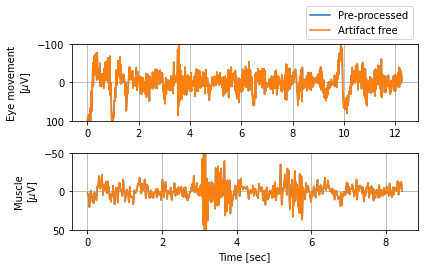

In [6]:
#%% Settings
f = 1           # File index [n]
a = 0          # Artifact index [n]
chan = "FP1"    # Channel to plot [string] 
scaling_factor = 1e6    # Scale data to [uV]
eye_ylims = [100, -100] # Limits for eye plot
mus_ylims = [50, -50] # Limits for muscle plot

#%% Create time vectors and select channel
time_eye = np.linspace(0, np.max(np.shape(eye_pre_eeg[f][a]))/srate[f], np.max(np.shape(eye_pre_eeg[f][a])))
time_mus = np.linspace(0, np.max(np.shape(mus_pre_eeg[f][a]))/srate[f], np.max(np.shape(mus_pre_eeg[f][a])))
chan_idx = eeg_valid_chans == chan

#%% Generate plot
[fig, ax] = plt.subplots(2,1)
ax[0].plot(time_eye, scaling_factor*eye_pre_eeg[f][a][chan_idx,:].T)
ax[0].plot(time_eye, scaling_factor*eye_clean[f][a][chan_idx,:].T)
ax[0].set_ylabel("Eye movement\n[$\mu$V]")
ax[0].legend(["Pre-processed", "Artifact free"], bbox_to_anchor=(1., 1.55))
ax[0].set_ylim(eye_ylims)
ax[0].grid()

ax[1].plot(time_mus, scaling_factor*mus_pre_eeg[f][a][chan_idx,:].T)
ax[1].plot(time_mus, scaling_factor*mus_clean[f][a][chan_idx,:].T)
ax[1].set_ylabel("Muscle\n[$\mu$V]")
ax[1].set_xlabel("Time [sec]")
ax[1].set_ylim(mus_ylims)
ax[1].grid()

plt.tight_layout()

# Power spectrum density

Plot the power spectrum density of the filtered (pre-processed) and the clean signal to see how the artifact removal tool modifies the spectrum

In [7]:
#%% Settings 
plot = False

#%% Calculate power spectrum of artifact
psd_eye_pre = eye_clean

#&& Settings
f = 0
a = 0
nperseg = artifact_min_duration * srate[0]

#&& Compute PSD
[freq, psd_eye_pre] = signal.welch(eye_pre_eeg[f][a], fs=srate[f], nperseg=nperseg)
[_   , psd_eye_clean] = signal.welch(eye_clean[f][a], fs=srate[f], nperseg=nperseg)
[_   , psd_mus_pre] = signal.welch(mus_pre_eeg[f][a], fs=srate[f], nperseg=nperseg)
[_   , psd_mus_clean] = signal.welch(mus_clean[f][a], fs=srate[f], nperseg=nperseg)

#&& Plot PSD
if plot:
    fmask = (freq<fc[1]) & (freq>5)

    [fig, ax] = plt.subplots(2,1)
    ax[0].plot(freq[fmask], psd_eye_pre[0,fmask])
    ax[0].plot(freq[fmask], psd_eye_clean[0,fmask])
    ax[0].legend(["pre", "clean"])
    ax[0].set_ylabel("Eye artifact \n[V$^2$/Hz]")

    ax[1].plot(freq[fmask], psd_mus_pre[0,fmask])
    ax[1].plot(freq[fmask], psd_mus_clean[0,fmask])
    ax[1].legend(["pre", "clean"])
    ax[1].set_ylabel("Muscle artifact \n[V$^2$/Hz]")
    ax[1].set_xlabel("Frequency [Hz]")

    plt.tight_layout()

# EEG Quality Index

Compute the [EEG Quality Index](../Functions/eeg_quality_index.py) of the artifact removed data with respect to the clean data.

In [8]:
# [print(len(eye_clean[f])) for f in range(n_files)]
a = eye_clean[9]

In [9]:
#%% Settings
# - Plot settings
plot = True     # Boolean to plot data without artifacts

# - EEG Quality Index settings
win = int(srate[0])  # Number of samples for sliding window [n]
slide = int(np.floor(srate[0]/20))               # Number of samples to slide the sliding window [n]

#%% Pre-allocate variables
# - Eye movement artifact
ct_eye_raw = np.zeros((n_files, n_artifacts, n_chans))      # Clean_total
cp_eye_raw = np.zeros((n_files, n_artifacts, 6, n_chans))   # Clean_percent
eqi_eye_raw =  np.zeros((n_files, n_artifacts,6, n_chans))  # EQI average

ct_eye_pre = np.zeros_like(ct_eye_raw)
cp_eye_pre = np.zeros_like(cp_eye_raw)
eqi_eye_pre = np.zeros_like(eqi_eye_raw)

ct_eye_art = np.zeros_like(ct_eye_raw)
cp_eye_art = np.zeros_like(cp_eye_raw)
eqi_eye_art = np.zeros_like(eqi_eye_raw)

# - Eye movement artifact
ct_mus_raw = np.zeros((n_files, n_artifacts, n_chans))      # Clean_total
cp_mus_raw = np.zeros((n_files, n_artifacts, 6, n_chans))   # Clean_percent
eqi_mus_raw =  np.zeros((n_files, n_artifacts,6, n_chans))  # EQI average

ct_mus_pre = np.zeros_like(ct_mus_raw)
cp_mus_pre = np.zeros_like(cp_mus_raw)
eqi_mus_pre = np.zeros_like(eqi_mus_raw)

ct_mus_art = np.zeros_like(ct_eye_raw)
cp_mus_art = np.zeros_like(cp_eye_raw)
eqi_mus_art = np.zeros_like(eqi_eye_raw)

def trim_to_window(data, axis, window):
    """
        Trims input 2D data to max multiple of window size along axis
    """
    data_length = np.size(data, axis)
    multiple_window = np.floor(data_length/window)
    trim_length = int(window * multiple_window)

    if axis == 0:
        trimmed_data = data[:trim_length,:]
    elif axis == 1:
        trimmed_data = data[:, :trim_length]

    return trimmed_data

for f in range(n_files):
    for a in range(n_artifacts):
        # Trim temp data for EQI computation
        trim_clean_eeg = trim_to_window(clean_pre_eeg[f], axis=1, window=win)

        trim_eye_eeg_raw = trim_to_window(eye_eeg[f][a], axis=1, window=win)
        trim_eye_eeg_pre = trim_to_window(eye_pre_eeg[f][a], axis=1, window=win)
        trim_eye_eeg_art = trim_to_window(eye_clean[f][a], axis=1, window=win)

        trim_mus_eeg_raw = trim_to_window(mus_eeg[f][a], axis=1, window=win)
        trim_mus_eeg_pre = trim_to_window(mus_pre_eeg[f][a], axis=1, window=win)
        trim_mus_eeg_art = trim_to_window(mus_clean[f][a], axis=1, window=win)

        # Comput EEG Quality index
        [ct_eye_raw[f,a,:], cp_eye_raw[f,a,:,:], eqi_eye_raw[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_eye_eeg_raw, srate_clean=win, srate_test=win, window=win, slide=slide)
        [ct_eye_pre[f,a,:], cp_eye_pre[f,a,:,:], eqi_eye_pre[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_eye_eeg_pre, srate_clean=win, srate_test=win, window=win, slide=slide)
        [ct_eye_art[f,a,:], cp_eye_art[f,a,:,:], eqi_eye_art[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_eye_eeg_art, srate_clean=win, srate_test=win, window=win, slide=slide)

        [ct_mus_raw[f,a,:], cp_mus_raw[f,a,:,:], eqi_mus_raw[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_mus_eeg_raw, srate_clean=win, srate_test=win, window=win, slide=slide)
        [ct_mus_pre[f,a,:], cp_mus_pre[f,a,:,:], eqi_mus_pre[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_mus_eeg_pre, srate_clean=win, srate_test=win, window=win, slide=slide)
        [ct_mus_art[f,a,:], cp_mus_art[f,a,:,:], eqi_mus_art[f,a,:,:]] = eeg_quality_index.scoring(trim_clean_eeg, trim_mus_eeg_art, srate_clean=win, srate_test=win, window=win, slide=slide)

# [ct_eye_pre, cp_eye_pre, eqi_eye_pre] = eeg_quality_index.scoring(
#     clean_eeg = trim_clean_eeg,
#     test_eeg = trim_eye_eeg_pre,
#     srate_clean = win,
#     srate_test = win,
#     window = win,
#     slide = slide)

# [ct_eye_art, cp_eye_art, eqi_eye_art] = eeg_quality_index.scoring(
#     clean_eeg = trim_clean_eeg,
#     test_eeg = trim_eye_eeg_art,
#     srate_clean = win,
#     srate_test = win,
#     window = win,
#     slide = slide)

# trim_clean_eeg = clean_eeg[0][:,window_size*np.floor(np.max(np.shape(clean_eeg[0]))/window_size)]
# trim_eye_eeg = eye_eeg[0][1][:, window_size*np.floor(np.max(np.shape(eye_eeg)))]


# #%% Compute EEG Quality Index

# f = 0
# [ct_eye_raw,_,eqi_eye_raw] = eeg_quality_index.scoring(clean_eeg[0], eye_eeg[0][2], srate[f], srate[f], window=srate[f], slide=1)
# [ct_eye_art,_,eqi_eye_art] = eeg_quality_index.scoring(clean_eeg[0], eye_clean[0][2], srate[f], srate[f], window=srate[f], slide=1)

## Visualize Quality Index

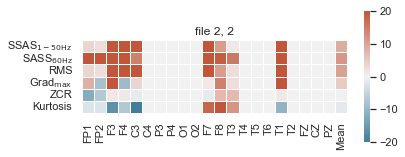

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:title={'center':'file 2, 2'}>)

In [25]:

# Enable these lines for RAW, pre-processed, ART
# eeg_quality_index.heatmap(cp_eye_raw, chans=eeg_valid_chans.tolist(), title="RAW")
# eeg_quality_index.heatmap(cp_eye_pre, chans=eeg_valid_chans.tolist(), title="Pre-processed")
# eeg_quality_index.heatmap(cp_eye_art, chans=eeg_valid_chans.tolist(), title="ART")

# Enable this line to see improvement in art vs pre-processed
f = 2
a = 2
vals = [-20, 20]


eeg_quality_index.heatmap(cp_eye_art[f][a]-cp_eye_pre[f][a], vals=vals, chans=eeg_valid_chans.tolist(), title=f"file {f}, {a}")

# Statistical Analysis

Compute a t-test to test whether there is a difference in EEG quality between the artifact removed data, and the pre-processed data

Note 
- p-values will return `NaN` when the two populations are exactly the same. This occurs when the artifact removal tool did not have any effect on the processed data

In [36]:
import scipy.stats as stats
reshaped_art = cp_eye_art.reshape((30,6,21))
reshaped_pre = cp_eye_pre.reshape((30,6,21))

[ttest, p] = stats.ttest_rel(reshaped_art, reshaped_pre, axis=0, alternative='greater')
# np.shape(cp_eye_art.reshape((30,6,21)))

In [42]:
c = 8
# data_temp = np.concatenate((reshaped_art[:,:,c], reshaped_pre[:,:,c]), axis=0)
data_temp = (reshaped_art[:,:,c] - reshaped_pre[:,:,c])

sem = np.std(data_temp, axis=0, ddof=1)
print(sem)
# data_temp = np.array((reshaped_art[:,:,c], reshaped_pre[:,:,c]))

[0. 0. 0. 0. 0. 0.]
